# Spaceship Titanic
### Predict which passengers are transported to an alternate dimension


Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

File and Data Field Descriptions
train.csv - Personal records for about two-thirds (aprox. 8700) of the passengers, to be used as training data.
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (aprox. 4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.]

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [4]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [6]:
df_test.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
df_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [16]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [17]:
df_not_null = df_train.dropna()

In [18]:
df_not_null.shape

(6606, 14)

In [19]:
df_train.shape

(8693, 14)

##### If we dropna, we will lose a substantial amount of information


##### We will need to handle the null values for each variable individually.

# EDA

### UNDERSTANDING CATEGORIC VARIABLES

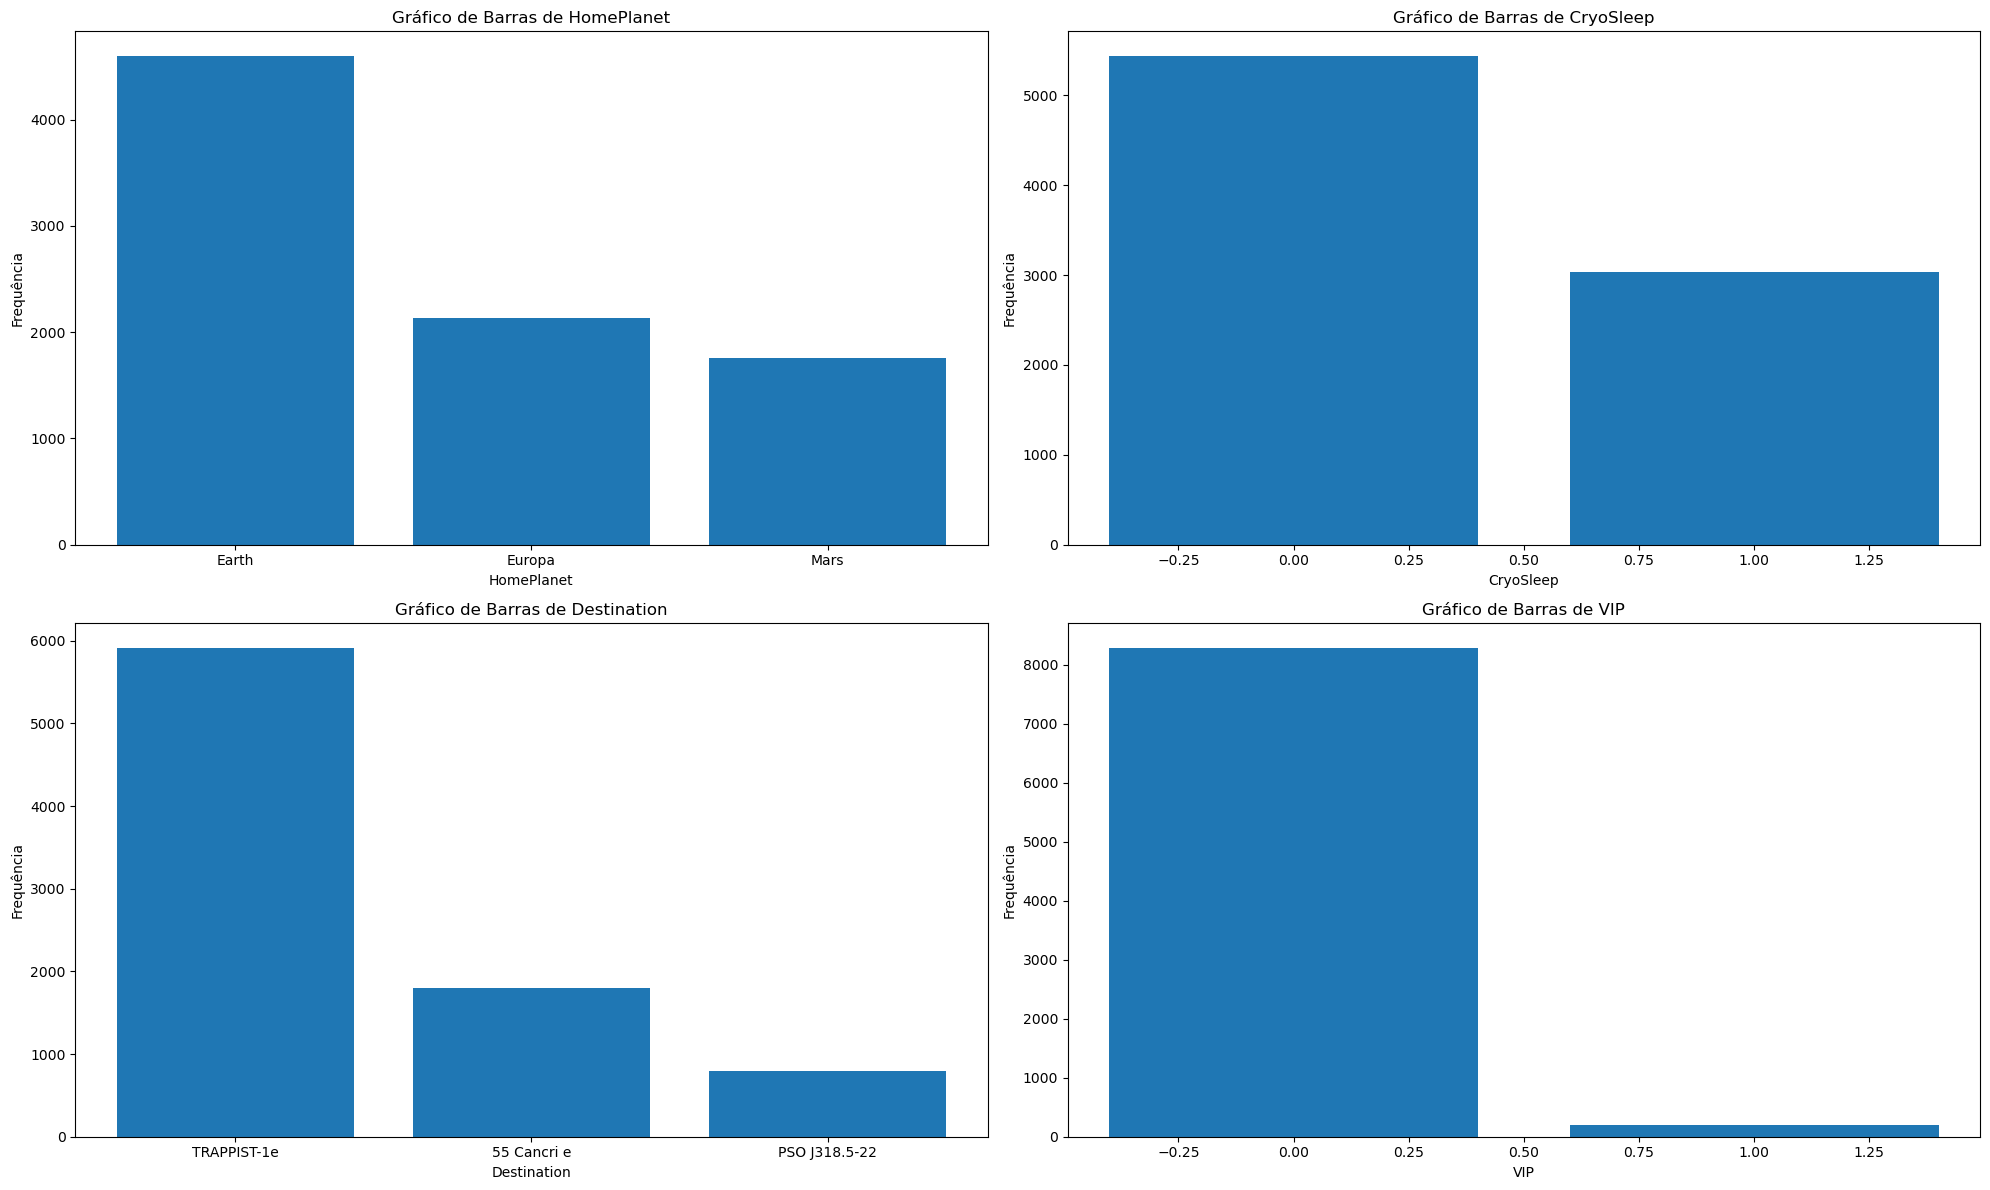

In [40]:
df_categoric = df_train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP']]
num_columns = len(df_categoric.columns)

fig, axs = plt.subplots(2, 2, figsize=(20, 6*2))

# Ao invés de usar axs[rows col], usaremos axs[i] devido ao ravel()
axs = axs.ravel()

for i, column in enumerate(df_categoric.columns):
    value_counts = df_categoric[column].dropna().value_counts()
    axs[i].bar(value_counts.index, value_counts.values)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequência')
    axs[i].set_title('Gráfico de Barras de {}'.format(column))

# Fazer com que os espaçamentos sejam ajustados automaticamente
plt.tight_layout()

plt.show()

##### Count the values of all categorical variables

In [56]:
df_counts = df_categoric.apply(pd.Series.value_counts).fillna('-')
print(df_counts)

              HomePlanet CryoSleep Destination     VIP
Earth             4602.0         -           -       -
Europa            2131.0         -           -       -
Mars              1759.0         -           -       -
False                  -    5439.0           -  8291.0
True                   -    3037.0           -   199.0
TRAPPIST-1e            -         -      5915.0       -
55 Cancri e            -         -      1800.0       -
PSO J318.5-22          -         -       796.0       -


#### CROSSTAB VISUAL

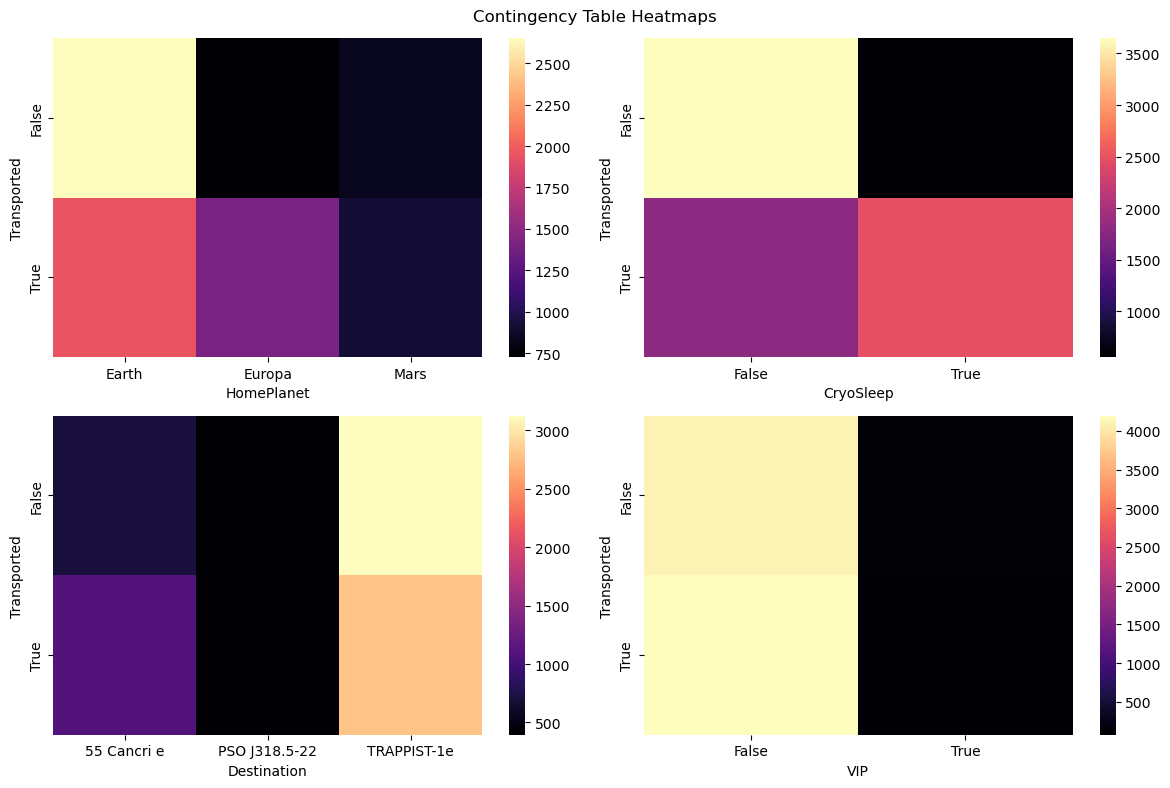

In [84]:
# Create a list of column names for subplots
columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Contingency Table Heatmaps')

# Plot heatmaps in subplots
for i, column in enumerate(columns):
    contingency_table = pd.crosstab(index=df_categoric_crosstab['Transported'], columns=df_categoric_crosstab[column])
    ax = axs[i // 2, i % 2]
    sns.heatmap(contingency_table, cmap='magma', fmt='d', ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Transported')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Maybe we should be interested in cryosleep: true and non-VIP individuals

In [116]:
df_categoric = df_train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP','Transported']]

for column in df_categoric:
    contingency_table = pd.crosstab(index=df_categoric_crosstab['Transported'], columns=df_categoric_crosstab[column])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    # Imprimir os resultados
    print("Variable:", column)
    print("Chi-square test statistic:", chi2)
    print("P-value:", p_value)
    print("Degrees of freedom:", dof)
    print("Expected frequencies:\n", np.round(expected, 1))
    print("\n--------------------------------------------- \n")


Variable: HomePlanet
Chi-square test statistic: 324.9013834000382
P-value: 2.809059985251311e-71
Degrees of freedom: 2
Expected frequencies:
 [[2285.3 1058.2  873.5]
 [2316.7 1072.8  885.5]]

--------------------------------------------- 

Variable: CryoSleep
Chi-square test statistic: 1859.6127129888841
P-value: 0.0
Degrees of freedom: 1
Expected frequencies:
 [[2697.7 1506.3]
 [2741.3 1530.7]]

--------------------------------------------- 

Variable: Destination
Chi-square test statistic: 106.39215684982227
P-value: 7.892901466137099e-24
Degrees of freedom: 2
Expected frequencies:
 [[ 893.5  395.1 2936.3]
 [ 906.5  400.9 2978.7]]

--------------------------------------------- 

Variable: VIP
Chi-square test statistic: 11.542020738162797
P-value: 0.0006804064556968345
Degrees of freedom: 1
Expected frequencies:
 [[4117.2   98.8]
 [4173.8  100.2]]

--------------------------------------------- 

Variable: Transported
Chi-square test statistic: 8689.000250089412
P-value: 0.0
Degrees of

##### All variables show significant associations with the "Transported" variable, indicating their potential influence on the transportation outcome.

In [117]:
expected

array([[2141.86414356, 2173.13585644],
       [2173.13585644, 2204.86414356]])